# Playground Self Supervised Learning: Fashionset Classification (FashionMNIST Dataset)

**Fashion MNIST** dataset ready in https://pytorch.org/docs/master/torchvision/datasets.html#fashion-mnist

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
import torchvision.transforms.functional as TF
import random
from matplotlib import pyplot as plt
from random import randint




In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define a transform to normalize the data
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

In [4]:
root_dir = 'fashion_mnist'
batch_size=64

# Download and load the training data
trainset = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
image, label = trainset[0]
print(image.size())
print(label)

torch.Size([1, 28, 28])
9


In [6]:
#We can iterate over the dataset
for xs, ys in trainloader:
    print(xs.size(), ys.size())
    print(ys)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([1, 5, 1, 8, 2, 0, 5, 2, 4, 2, 1, 3, 0, 2, 2, 5, 6, 8, 0, 4, 9, 5, 0, 9,
        1, 9, 4, 0, 5, 3, 0, 2, 9, 3, 6, 1, 0, 4, 1, 4, 3, 0, 8, 5, 8, 6, 1, 7,
        0, 9, 6, 3, 1, 9, 7, 8, 3, 3, 0, 9, 3, 3, 0, 7])


#### Display random images

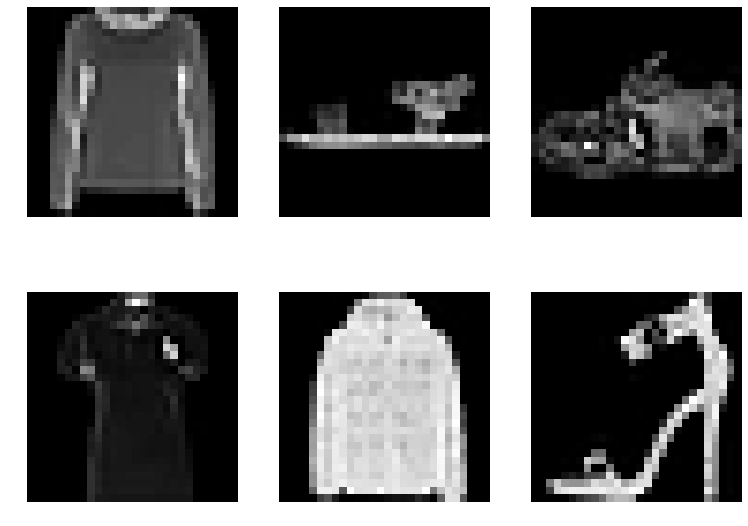

In [53]:
from matplotlib import pyplot as plt
from random import randint

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(trainset))
    axes[i].imshow(trainset[index][0].view(28, 28), cmap='gray')
    axes[i].axis('off')    

#### Display random rotated images

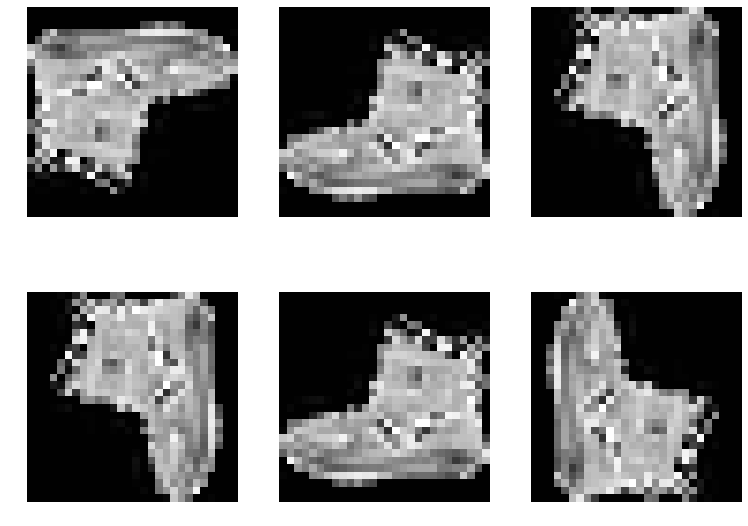

In [8]:
transforms = ToPILImage()
    
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    angle = random.choice([0, 90, 180, 270])
    axes[i].imshow(TF.rotate(transforms(trainset[0][0]), angle), cmap='gray')
    axes[i].axis('off') 

### Create augmented dataset

In [152]:
class FashionMinstAugmentedDataset(Dataset):

    def __init__(self, data, target, transform):
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    

    def __getitem__(self, index):
        angle = random.choice([0, 90, 180, 270])
        
        datapoint = self.transform(self.data[index], angle)
        
        # need to use ints for classes [0, 90, 180, 270]
        if angle == 0:
            rotation_class = 0 
        if angle == 90:
            rotation_class = 1
        if angle == 180:
            rotation_class = 2
        if angle == 270:
            rotation_class = 3
        
        target = rotation_class

        return datapoint, target

In [153]:
# Rotate given images by given angle

def my_segmentation_transforms(image, angle):
    image = TF.to_pil_image(image)
    image = TF.resize(image, 32, interpolation=2)
    image = TF.rotate(image, angle)
    image = TF.to_tensor(image)
    image = TF.normalize(image, (0.5, ), (0.5, ))

    return image

In [154]:
batch_size=64
n_train = int(len(trainset) * 0.8)

train_augmented = FashionMinstAugmentedDataset(
    data=trainset.data[:n_train], 
    target=trainset.targets[:n_train], 
    transform=my_segmentation_transforms)
trainloader_augmented = DataLoader(train_augmented, batch_size=batch_size, shuffle=True, num_workers=32)


val_augmented = FashionMinstAugmentedDataset(
    data=trainset.data[n_train:], 
    target=trainset.targets[n_train:], 
    transform=my_segmentation_transforms)
valloader_augmented = DataLoader(val_augmented, batch_size=batch_size, shuffle=True, num_workers=32)


test_augmented = FashionMinstAugmentedDataset(
    data=testset.data, 
    target=testset.targets, 
    transform=my_segmentation_transforms)
testloader_augmented = DataLoader(test_augmented, batch_size=batch_size, shuffle=True, num_workers=32)

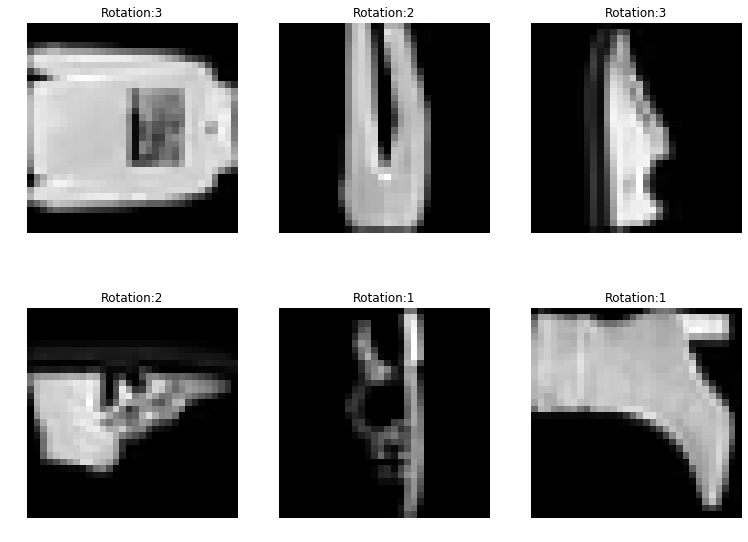

In [159]:
f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]
for i in range(6):
    index = randint(0, len(train_augmented))
    image, label = train_augmented[index]
    axes[i].imshow(np.asarray(image.view(32, 32)), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')   

## Models

#### Train

In [132]:
import time
from torch.autograd import Variable

def train(model, loss_fn, optimizer, scheduler, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataloader = None
    dataset_size = 0
    
    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
                dataloader = trainloader_augmented
                dataset_size = len(train_augmented)
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valloader_augmented
                dataset_size = len(val_augmented)

                
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            
            for data in dataloader:
                # get the inputs
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = loss_fn(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects / dataset_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### ResNet 18

In [119]:
model_resnet18 = resnet18(pretrained=False)

In [120]:
model_resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_resnet18.avgpool = nn.AdaptiveAvgPool2d(1)
model_resnet18.fc = nn.Linear(16*32, 4)

In [121]:
# model_resnet18

In [130]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=10

In [133]:
model = train(model_resnet18, loss_fn, optim, sched, eps)

Epoch 1/10
train Loss: 0.0016 Acc: 0.9651
val Loss: 0.0012 Acc: 0.9737
Epoch 2/10
train Loss: 0.0013 Acc: 0.9727
val Loss: 0.0013 Acc: 0.9739
Epoch 3/10
train Loss: 0.0012 Acc: 0.9755
val Loss: 0.0011 Acc: 0.9773
Epoch 4/10
train Loss: 0.0007 Acc: 0.9863
val Loss: 0.0006 Acc: 0.9867
Epoch 5/10
train Loss: 0.0005 Acc: 0.9886
val Loss: 0.0006 Acc: 0.9871
Epoch 6/10
train Loss: 0.0005 Acc: 0.9900
val Loss: 0.0006 Acc: 0.9882
Epoch 7/10
train Loss: 0.0005 Acc: 0.9904
val Loss: 0.0006 Acc: 0.9874
Epoch 8/10
train Loss: 0.0004 Acc: 0.9918
val Loss: 0.0005 Acc: 0.9885
Epoch 9/10
train Loss: 0.0004 Acc: 0.9922
val Loss: 0.0005 Acc: 0.9883
Epoch 10/10
train Loss: 0.0003 Acc: 0.9926
val Loss: 0.0005 Acc: 0.9887
Training complete in 14m 22s
Best val Acc: 0.988750


### ResNet in PyTorch for CIFAR-10
#### https://github.com/Udacity-PyTorchChallenge-Students-Group/Convolutional-Neural-Networks/blob/master/2_ResNets/resnets_Paper.py

In [134]:
import torch
import torch.nn as nn
from torch.autograd import Variable


def flatten(x): 
    return x.view(x.size(0), -1)


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)



class BasicBlock(nn.Module):

    expansion = 1       

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.conv2 = conv3x3(planes, planes)

        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        self.stride = stride

    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.downsample = downsample
        
        self.stride = stride
        
    def forward(self, x):

        residue = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(x)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            residue = self.downsample(x)

        out += residue
        out = self.relu(out)
        return out
            
            
class ResNet(nn.Module):

    def __init__(self, depth, name, num_classes=10, block=BasicBlock):
        super(ResNet, self).__init__()

        assert (depth - 2) % 6 == 0, 'Depth should be 6n + 2'
        n = (depth - 2) // 6

        self.name = name
        block = BasicBlock
        self.inplanes = 16
        fmaps = [16, 32, 64] # CIFAR10

        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, fmaps[0], n, stride=1)
        self.layer2 = self._make_layer(block, fmaps[1], n, stride=2)
        self.layer3 = self._make_layer(block, fmaps[2], n, stride=2)

        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.flatten = flatten
        self.fc = nn.Linear(fmaps[2] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        ''' Between layers convolve input to match dimensions -> stride = 2 '''

        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x, print_sizes=False):
        
        if print_sizes:
            print('Sizes of the tensors inside each node: \n')
            print("\t In Model: input size", x.size())
        
        x = self.relu(self.bn(self.conv(x)))    # 32x32
        
        x = self.layer1(x)                      # 32x32
        x = self.layer2(x)                      # 16x16
        x = self.layer3(x)                      # 8x8

        x = self.avgpool(x)                     # 1x1
        x = self.flatten(x)                     # Flatten
        x  = self.fc(x)                         # Dense
        
        if print_sizes:
            print("\t In Model: output size", x.size())
            
        return x

In [135]:
def ResNet20(**kwargs):    
    return ResNet(name = 'ResNet20', depth = 20, **kwargs)

In [145]:
resnet20 = ResNet20()
resnet20.conv = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [161]:
# Criteria NLLLoss which is recommended with Softmax final layer
loss_fn = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optim = torch.optim.Adam(resnet20.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
sched = torch.optim.lr_scheduler.StepLR(optimizer=optim, step_size=4, gamma=0.1)

# Number of epochs
eps=5

resnet20_trained = train(resnet20, loss_fn, optim, sched, eps)

Epoch 1/5
train Loss: 0.0039 Acc: 0.9186
val Loss: 0.0025 Acc: 0.9484
Epoch 2/5
train Loss: 0.0017 Acc: 0.9650
val Loss: 0.0015 Acc: 0.9697
Epoch 3/5
train Loss: 0.0014 Acc: 0.9704
val Loss: 0.0015 Acc: 0.9678
Epoch 4/5
train Loss: 0.0012 Acc: 0.9750
val Loss: 0.0009 Acc: 0.9814
Epoch 5/5
train Loss: 0.0007 Acc: 0.9854
val Loss: 0.0006 Acc: 0.9866
Training complete in 16m 13s
Best val Acc: 0.986583
